In [1]:
import numpy as np
import matplotlib.pyplot as plt

We are going to minimize the function
\begin{align}
    \mathcal{G}(\mu) = \mathcal{E}_F(\mu) + \int\log(\mu(x))d\mu(x).
\end{align}
If we define
$$
F(x) = 0.5|x|^2
$$
and
$$
H(\mu) = \int\log(\mu(x))d\mu(x)
$$
then note that we are going to minimize $\mathcal{G}$ which is merely an integral over a quadratic function according to the measure $\mu$, regularized by negative entropy. We want to find the measure that minimizes this value. In our case specifically, this minimization amounts to minimizing the KL divergence, i.e., $\mathcal{G}(\mu)$ is the KL divergence between $\mu$ and $\mu_*$ where $\mu_*$ is standard Gaussian distribution. The idea is that we want to iteratively update the measure $\mu_n$ according to the proximal-gradient update scheme
\begin{align}
    \nu_{n+1} &= (I - \gamma\nabla F)_{\#}\mu_n\\
    \mu_{n+1} &\in \mathrm{JKO}_{\gamma H}(\nu_{n+1}).
\end{align}
The idea is that as $n\to\infty$, we have that $\mu_n \to \mu_*$. The authors give convergence guarantees and convergence rates which we're not going to look at here. But, in our specific example, we know that this update scheme is equivalent to
\begin{align}
    m_{k+1} &= m + (I-\gamma\Sigma^{-1})(m_k - m)\\
    \Sigma_{k+1}(I - \gamma\Sigma_{k+1}^{-1})^2 &= \Sigma_k (I-\gamma\Sigma^{-1}),
\end{align}
where $m$ represents the mean and $\Sigma$ represents the variance (covariance matrix specifically of the iterative distribution). We may use this update structure directly on the mean and variance since every iterative distributional update $\mu_n$ is Gaussian necessarily and because we have a closed form for the $\mathrm{JKO}$ operator. So, in our example, we resort to 1D optimal transport through these iterative updates (which we may perform specifically on just the mean and variance through these updates), we have $m_* = 0$ and $\sigma_* = 1$, and initialize with $m_0 = 10$ and $\sigma_0 = 100$. At every step, we also have a closed form expression for the Wasserstein-2 distance $W^2 (\mu_n, \mu_*) = m_{n}^2 + (1 - \sqrt{\sigma_n})^2$. We now code all of this up.

In [2]:
# Initialize model parameters (mean and variance) according to explanation above; also parameters of distribution we're trying to match
m0 = 10
s0 = 100
msg = 0
ssg = 1
gamma = 0.2 # -> This is just the "step size" in the proximal step
d = 5000 # how many particles we have at each step

# Create lamda function of Wasserstein-2 distance
Wass = lambda m,s: (msg-m)**2 + (ssg - np.sqrt(s))**2

# Initializing arrays that will keep updates of means and variances
n = 100
ms = np.zeros(n+1)
ss = np.zeros(n+1)
Ws = np.zeros(n+1)
Ws_bound = np.zeros(n+1)
particles = []
particles.append(np.random.normal(m0,np.sqrt(s0),d))

# Assigning variables to first iterate of arrays
ms[0] = m0
ss[0] = s0
Ws[0] = Wass(m0,s0)
Ws_bound[0] = Wass(m0,s0)

# Set iterative updates
mi = m0
si = s0
for i in range(1,n+1):
    # First, we compute the iterative update for the mean
    mi = msg + (1-gamma/ssg)*(mi-msg)
    ms[i] = mi

    # Next, we compute the iterative update for the variance, which is just a bit more convoluted
    C = si * (1-gamma/ssg)**2
    Delta = (C + 2*gamma)**2 - 4*gamma**2
    si = 0.5*(C + 2*gamma + np.sqrt(Delta))
    ss[i] = si

    #Last, we compute the Wasserstein-2 distance
    
    
    Ws[i] = Wass(mi,si)
    Ws_bound[i] += (1-gamma)*Ws_bound[i-1]

    #Append to particles list
    
    xh = msg + (1-gamma/ssg)*(particles[i-1] - msg*(particles[i-1]**0))
    xx = mi + 1/(1-gamma/si)*(xh - mi*(xh**0))  
    
    particles.append(xx)
    #particles.append(np.random.normal(mi,si,d))

In [3]:
normal = lambda x,m,s: (1/(np.sqrt(2*np.pi*s)))*(np.exp(-0.5*(x-m)**2/(s)))

\begin{align}
    p(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2\sigma^2}(x-\mu)^2}
\end{align}

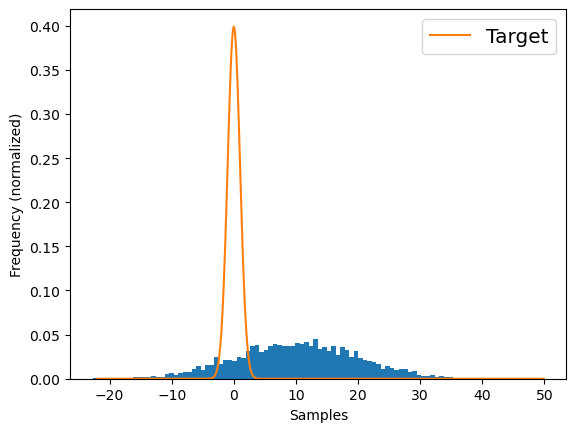

In [4]:
xs = np.arange(np.ceil(np.min(particles[0])),np.ceil(np.max(particles[0])),step=0.1)
plt.hist(particles[0],bins=100,density=True)
normies = [normal(x,ms[0],ss[0]) for x in xs]
normies_std = [normal(x,msg,ssg) for x in xs]
plt.plot(xs,normies_std,label="Target")
plt.ylabel("Frequency (normalized)")
plt.xlabel("Samples")
plt.legend(fontsize = 'x-large')

In [5]:
for i in range(n+1):
    plt.figure()
    xs = np.arange(np.minimum(np.ceil(np.min(particles[i])),-7),np.maximum(np.ceil(np.max(particles[i])),7),step=0.1)
    plt.hist(particles[i],bins=100,density=True)
    normies = [normal(x,ms[i],ss[i]) for x in xs]
    normies_std = [normal(x,msg,ssg) for x in xs]
    plt.plot(xs,normies_std,label="Target")
    plt.ylabel("Frequency (normalized)")
    plt.xlabel("Samples")
    #plt.xlim((-30,50))
    plt.legend()
    plt.savefig("steps/iter_" + str(i+1) + ".png")
    plt.close()

In [6]:
import glob
files = glob.glob(r"steps/*.png")

In [7]:
# Define a custom key function to extract the iteration number from each filename
def get_iteration_number(filename):
    return int(filename.split('_')[-1].split('.')[0])

# Sort the list of filenames using the custom key function
sorted_filenames = sorted(files, key=get_iteration_number)

In [8]:
from PIL import Image

In [9]:
image_array = []
for my_file in sorted_filenames:
    
    image = Image.open(my_file)
    image_array.append(image)

C:\Users\wiets\AppData\Local\Temp\ipykernel_6268\1616135278.py:7: FutureWarning: The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  print('image_arrays shape:', np.array(image_array).shape)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (101,) + inhomogeneous part.

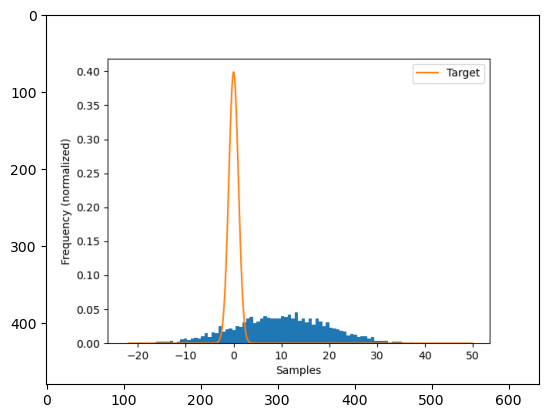

In [10]:
import matplotlib.animation as animation

# Create the figure and axes objects
fig, ax = plt.subplots()

# Set the initial image
im = ax.imshow(image_array[0], animated=True)

In [11]:
def update(i):
    im.set_array(image_array[i])
    return im, 

In [12]:
# Create the animation object
animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=200, blit=True,repeat_delay=10,)

# Show the animation
plt.show()

animation_fig.save("steps/animated_GMM.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


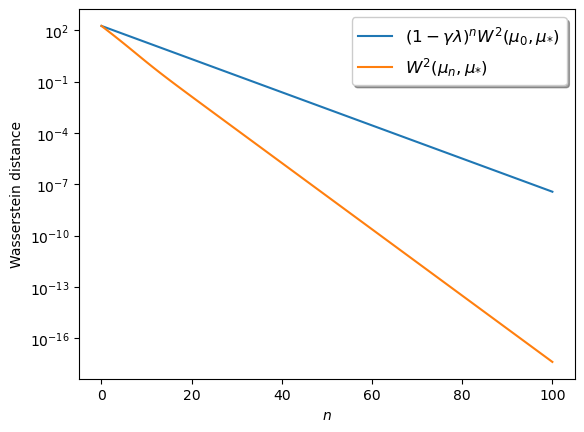

In [13]:
bound = plt.plot(Ws_bound, label = '$(1-\gamma\lambda)^{n}W^2(\mu_0,\mu_{*})$')
Err = plt.plot(Ws, label = '$W^2(\mu_n,\mu_{*})$')

legend = plt.legend(loc = 1, shadow = True, fontsize = 'large')
plt.ylabel('Wasserstein distance')
plt.xlabel('$n$')
plt.yscale('log')
plt.savefig('Wass_distance/Wass.png')

plt.show()

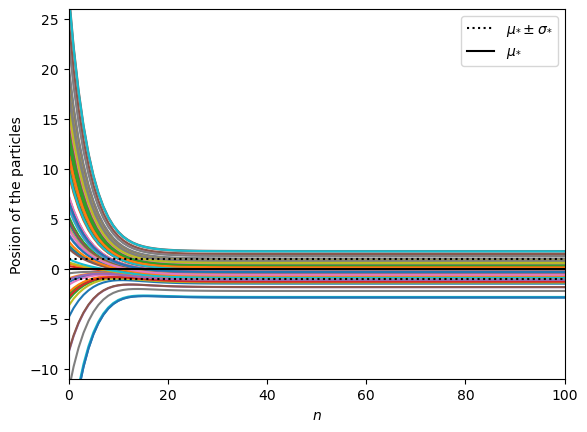

In [18]:
import random

Indi = []
NN = 100
for i in range(0,NN):
    indic = random.randint(0,d-1)
    Indi.append(indic)

plot_part = [[0 for _ in range(n+1)] for _ in range(NN)]
for i1 in range(n+1):
    x = particles[i1]
    for i2 in range(NN):
        plot_part[i2][i1] = x[Indi[i2]]
        
plt.figure()
for i1 in range(NN):
    plt.plot(range(n+1),plot_part[i1])
plt.ylabel("Posiion of the particles")
plt.xlabel('$n$')
#plt.xlim((-30,50))
plt.axhline(y=msg+ssg**2, color='k', linestyle=':',label = '$\mu_{*}\pm\sigma_{*}$')
plt.axhline(y=msg, color='k', linestyle='-',label = '$\mu_{*}$')
plt.axhline(y=msg-ssg**2, color='k', linestyle=':')
plt.xlim((0,n))
plt.ylim((-11,26))
plt.legend()
plt.savefig("steps/Trajectory.png")